# Importing Libraries

In [13]:
import sys
sys.path
sys.path.append('/home/prashant.singh1/.local/lib/python3.5/site-packages')

In [14]:
! pip install pandas --user
! pip install numpy --user
! pip install scipy --user
! pip install scikit-learn --user
! pip install matplotlib --user
! pip install seaborn --user
! pip install datetime --user

In [15]:
import pandas
import psycopg2 
import pandas.io.sql as psql
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime

# Connecting to database

In [16]:
conn = psycopg2.connect("dbname='postgres' user='msuuser' host='10.1.2.60' password='password@123'")
tripdata2017 = psql.read_sql("""SELECT * FROM "msu_greco"."fordgobike_tripdata_2017" """, conn) 
tripdata201801 = psql.read_sql("""SELECT * FROM "msu_greco"."fordgobike_tripdata_201801" """, conn) 
tripdata201802 = psql.read_sql("""SELECT * FROM "msu_greco"."fordgobike_tripdata_201802" """, conn) 
tripdata201803 = psql.read_sql("""SELECT * FROM "msu_greco"."fordgobike_tripdata_201803" """, conn) 
tripdata201804 = psql.read_sql("""SELECT * FROM "msu_greco"."fordgobike_tripdata_201804" """, conn) 
tripdata201805 = psql.read_sql("""SELECT * FROM "msu_greco"."fordgobike_tripdata_201805" """, conn)
tripdata201806 = psql.read_sql("""SELECT * FROM "msu_greco"."fordgobike_tripdata_201806" """, conn)
tripdata201807 = psql.read_sql("""SELECT * FROM "msu_greco"."fordgobike_tripdata_201807" """, conn)

In [17]:

tripdata201801 = tripdata201801.drop(columns = ["bike_share_for_all_trip","row.names"])
tripdata201802 = tripdata201802.drop(columns = ["bike_share_for_all_trip","row.names"])
tripdata201803 = tripdata201803.drop(columns = ["bike_share_for_all_trip","row.names"])
tripdata201804 = tripdata201804.drop(columns = ["bike_share_for_all_trip","row.names"])
tripdata201805 = tripdata201805.drop(columns = ["bike_share_for_all_trip","row.names"])
tripdata201806 = tripdata201806.drop(columns = ["bike_share_for_all_trip","row.names"])
tripdata201807 = tripdata201807.drop(columns = ["bike_share_for_all_trip","row.names"])
tripdata2017 = tripdata2017.drop(columns = "row.names")  


## Merging all tables togehter

In [37]:

Final_Table = pandas.concat([tripdata2017,tripdata201801,tripdata201802,tripdata201803,tripdata201804,tripdata201805,tripdata201806,tripdata201807])


## Changing date to appropriate format

In [19]:
Final_Table['start_time'] =  pandas.to_datetime(Final_Table['start_time'], format='%Y-%m-%d %H:%M:%S.%f')
Final_Table['end_time'] =  pandas.to_datetime(Final_Table['end_time'], format='%Y-%m-%d %H:%M:%S.%f')


In [20]:
q75, q25 = np.percentile(Final_Table.duration_sec, [75 ,25])
iqr = q75 - q25

min = q25 - (iqr*3)
max = q75 + (iqr*3)


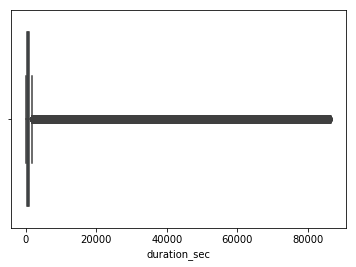

In [21]:
sns.boxplot(x=Final_Table['duration_sec'])


### Before outlier treatment

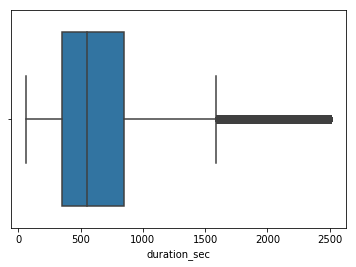

In [22]:

Final_Table = Final_Table[~((Final_Table.duration_sec < min) | (Final_Table.duration_sec > max))]
sns.boxplot(x= Final_Table['duration_sec'])


### After outlier treatment

In [23]:
#Understanding data types of final dataset

Final_Table.dtypes


duration_sec                        int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id                   object
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                     object
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bike_id                             int64
user_type                          object
member_birth_year                 float64
member_gender                      object
dtype: object

In [24]:
Period_Start = Final_Table.start_time.min()
Period_End = Final_Table.start_time.max()
Period_Duration = Period_End - Period_Start
timePeriodStat = pandas.DataFrame({"Analysis Start Date":[Period_Start.date()],
                                   "Analysis End Date" :[Period_End.date()],
                                   "Analysis Duration" :[Period_Duration]})
timePeriodStat  


,Analysis Duration,Analysis End Date,Analysis Start Date
0,398 days 14:09:42.955000,2018-07-31,2017-06-28


In [25]:
total_Bike_rides = len(Final_Table.duration_sec)
female_ride_count = len(Final_Table.member_gender[Final_Table['member_gender']=="Female"])
male_ride_count = len(Final_Table.member_gender[Final_Table['member_gender']=="Male"])
subscriber_ride_count = len(Final_Table.member_gender[Final_Table['user_type']=="Subscriber"])
customer_ride_count = len(Final_Table.member_gender[Final_Table['user_type']=="Customer"])

rideStat = pandas.DataFrame({"Total Bike rides":[total_Bike_rides],
                                   "Female " :[female_ride_count],
                                   "Male" :[male_ride_count],
                                    "Subscriber" :[subscriber_ride_count],
                                     "Customer" :[customer_ride_count]
                            })
rideStat


,Customer,Female,Male,Subscriber,Total Bike rides
0,231548,327066,1025927,1253571,1485119


In [26]:
currYear = datetime.date.today().year
Final_Table['age'] = currYear - Final_Table.member_birth_year   

ageStat = pandas.DataFrame({"Age >35":[len(Final_Table.age[Final_Table['age']>35])],
                            "Age >=20 & <35":[ len( Final_Table.age[(Final_Table['age']<35) & (Final_Table['age']>=20)])],
                            "Age <20":[len(Final_Table.age[Final_Table['age']<20])]                                  
                            })
ageStat
 





,Age <20,Age >35,Age >=20 & <35
0,6804,589764,720968


In [27]:
Gender_Trend = Final_Table[['start_time','member_gender']]
Gender_Trend = Gender_Trend[(Gender_Trend['member_gender']=="Female") | (Gender_Trend['member_gender']=="Male")| (Gender_Trend['member_gender']=="Other")]
Gender_Trend['Year'] = Gender_Trend['start_time'].dt.year
Gender_Trend['Month'] = Gender_Trend['start_time'].dt.month
Gender_Trend = Gender_Trend.groupby(['Year','Month','member_gender']).size().groupby(['Month','member_gender']).mean().reset_index(name ='Ride_Count')
Gender_Trend = Gender_Trend.pivot_table(index=['Month'], columns='member_gender',values='Ride_Count').reset_index()
Gender_Trend


member_gender,Month,Female,Male,Other
0,1,19926.0,64770.0,1158.0
1,2,23701.0,72164.0,1325.0
2,3,25033.0,74296.0,1472.0
3,4,29694.0,88235.0,1739.0
4,5,40864.0,120695.0,2544.0
5,6,22921.5,66300.0,1538.5
6,7,26828.5,79913.0,1664.0
7,8,14239.0,53247.0,716.0
8,9,18155.0,64100.0,1324.0
9,10,20270.0,72205.0,1353.0


([<matplotlib.axis.XTick at 0x7fe76296d160>,
 <a list of 12 Text xticklabel objects>)

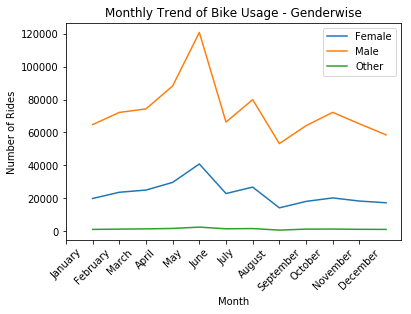

In [28]:


female = plt.plot(Gender_Trend['Month'],Gender_Trend['Female'])
male = plt.plot(Gender_Trend['Month'],Gender_Trend['Male'])
other = plt.plot(Gender_Trend['Month'],Gender_Trend['Other'])
plt.legend(["Female","Male","Other"])
plt.title('Monthly Trend of Bike Usage - Genderwise')
plt.ylabel('Number of Rides')
plt.xlabel('Month')
plt.xticks(np.arange(12),['January','February','March','April','May','June','July','August','September','October','November','December'], rotation=45)




### Findings
    ### Male are more into biking
    ### Less female are riding bike (So they need to promote biking in female)

In [29]:


typeTrendTable = Final_Table[['start_time','user_type']]
typeTrendTable['Year'] = typeTrendTable['start_time'].dt.year
typeTrendTable['Month'] = typeTrendTable['start_time'].dt.month
typeTrendTable = typeTrendTable.groupby(['Year','Month','user_type']).size().groupby(['Month','user_type']).mean().reset_index(name ='Ride_Count')
typeTrendTable = typeTrendTable.pivot_table(index=['Month'], columns='user_type',values='Ride_Count').reset_index()
typeTrendTable





/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


user_type,Month,Customer,Subscriber
0,1,10489.0,81805.0
1,2,12683.0,91098.0
2,3,13882.0,94338.0
3,4,18191.0,109124.0
4,5,25803.0,148253.0
5,6,14599.5,81588.0
6,7,19728.0,96880.5
7,8,18516.0,60121.0
8,9,20215.0,73479.0
9,10,18252.0,86706.0


([<matplotlib.axis.XTick at 0x7fe762a21860>,
 <a list of 12 Text xticklabel objects>)

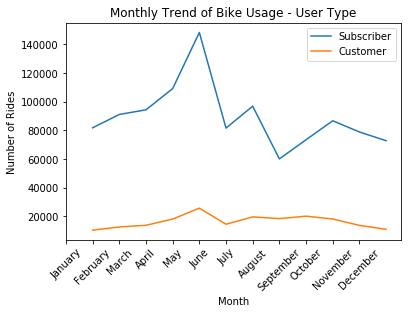

In [30]:
subscriber = plt.plot(typeTrendTable['Month'],typeTrendTable['Subscriber'])
cuustomer = plt.plot(typeTrendTable['Month'],typeTrendTable['Customer'])
plt.legend(["Subscriber","Customer"])
plt.title('Monthly Trend of Bike Usage - User Type')
plt.ylabel('Number of Rides')
plt.xlabel('Month')
plt.xticks(np.arange(12),['January','February','March','April','May','June','July','August','September','October','November','December'], rotation=45)


## Findings from above graph:
    ### Subscribers use more rides
    ### Peak in month of june(Summer Season people are riding more)

### Rolling data to weekly level 

In [31]:
Weekly_Trend = Final_Table[['start_time','member_gender','user_type']]
Weekly_Trend = Weekly_Trend[(Weekly_Trend['member_gender']=="Female") | (Weekly_Trend['member_gender']=="Male")]
Weekly_Trend['Year'] = Weekly_Trend['start_time'].dt.year
Weekly_Trend['Month'] = Weekly_Trend['start_time'].dt.month
Weekly_Trend['WeekDay']=Weekly_Trend['start_time'].dt.weekday
Weekly_Trend = Weekly_Trend.groupby(['Year','Month','WeekDay','user_type','member_gender']).size().groupby(['Month','WeekDay','user_type','member_gender']).mean().reset_index(name ='Ride_Count')
Weekly_Trend = Weekly_Trend.pivot_table(index=['Month','user_type','member_gender'], columns='WeekDay',values='Ride_Count').reset_index()
Weekly_Trend['WeekDays'] = (Weekly_Trend[0]+Weekly_Trend[1]+Weekly_Trend[2]+Weekly_Trend[3]+Weekly_Trend[4]+Weekly_Trend[5])/5
Weekly_Trend['WeekEnds'] = (Weekly_Trend[5]+Weekly_Trend[6])/2
Weekly_Trend = Weekly_Trend.drop(columns =[0,1,2,3,4,5,6])
Weekly_Trend


WeekDay,Month,user_type,member_gender,WeekDays,WeekEnds
0,1,Customer,Female,347.8,376.50
1,1,Customer,Male,618.8,529.50
2,1,Subscriber,Female,3352.0,1291.00
3,1,Subscriber,Male,11541.8,3928.50
4,2,Customer,Female,514.4,602.00
5,2,Customer,Male,828.4,757.50
6,2,Subscriber,Female,3883.8,1390.00
7,2,Subscriber,Male,12724.2,4190.00
8,3,Customer,Female,575.4,583.00
9,3,Customer,Male,869.0,715.00


In [32]:
weeklyTrendAnalysis = Weekly_Trend.groupby(['Month']).sum().reset_index()
weeklyTrendAnalysis


WeekDay,Month,WeekDays,WeekEnds
0,1,15860.4,6125.50
1,2,17950.8,6939.50
2,3,18553.6,7673.00
3,4,21599.2,9837.50
4,5,30101.8,11663.50
5,6,23911.7,15615.00
6,7,19500.4,8982.75
7,8,12585.4,4628.00
8,9,15321.0,6705.00
9,10,17065.6,6809.00


([<matplotlib.axis.XTick at 0x7fe762ec18d0>,
 <a list of 12 Text xticklabel objects>)

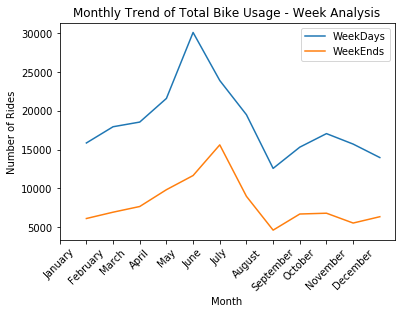

In [38]:
weekdays = plt.plot(weeklyTrendAnalysis['Month'],weeklyTrendAnalysis["WeekDays"])
weekends = plt.plot(weeklyTrendAnalysis['Month'],weeklyTrendAnalysis["WeekEnds"])
plt.legend(["WeekDays","WeekEnds"])
plt.title('Monthly Trend of Total Bike Usage - Week Analysis')
plt.ylabel('Number of Rides')
plt.xlabel('Month')
plt.xticks(np.arange(12),['January','February','March','April','May','June','July','August','September','October','November','December'], rotation=45)



### Findings:
    ### People are riding more in weekdays
    ### Promote riding bikes on weekends

([<matplotlib.axis.XTick at 0x7fe762c94128>,
 <a list of 12 Text xticklabel objects>)

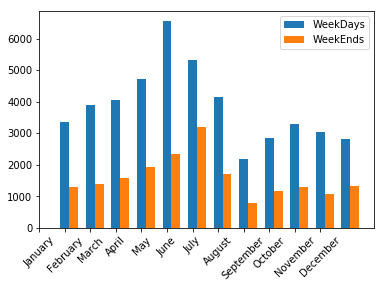

In [35]:

# Analysis for female riders across week

femaleWeeklyAnalysis = Weekly_Trend[Weekly_Trend['member_gender']=="Female"]
width = 0.35
weekdays =plt.bar(femaleWeeklyAnalysis['Month'],femaleWeeklyAnalysis['WeekDays'],width)

weekends =plt.bar(femaleWeeklyAnalysis['Month']+ width,femaleWeeklyAnalysis['WeekEnds'],width)
plt.legend(['WeekDays','WeekEnds'])
plt.xticks(np.arange(12),['January','February','March','April','May','June','July','August','September','October','November','December'], rotation=45)





## Showing trends in weekdays and weekends per month for Females

([<matplotlib.axis.XTick at 0x7fe762dc0358>,
 <a list of 12 Text xticklabel objects>)

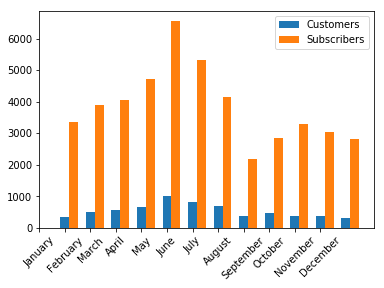

In [36]:

# Analysis for female over weekly level

Female_Weekly = femaleWeeklyAnalysis.drop(columns = ['WeekEnds','member_gender'])

Female_Weekly= Female_Weekly.pivot_table(index=['Month'], columns='user_type',values='WeekDays').reset_index()
Female_Weekly
width = 0.35
customers =plt.bar(Female_Weekly['Month'],Female_Weekly['Customer'],width)
subscribers =plt.bar(Female_Weekly['Month']+ width,Female_Weekly['Subscriber'],width)
plt.legend(['Customers','Subscribers'])
plt.xticks(np.arange(12),['January','February','March','April','May','June','July','August','September','October','November','December'], rotation=45)

### One time customers are riding far less than subcribers
### Above graph shows comparison between customers and subscribers across month



# Reccomendations -
##   Target more on quarter 4 as it has least number of people riding bikes
##   Target month of may, june and july as it has maximum potential
##   Target more on new getting and retaining new customers
    ### Should put out more offers and pers for 1st customers
    ### Regularly giving motivation for riders in quarter 3
##   Target weekdays and try to get more and more revenue out of it
##   Target female riders as their number is far less
    ### Special offers for female riders can be put out
